# CMLS - Homework 1 - Assignment 4

Link utili:
* [Paper](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf) di riferimento
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) in SKLearn
* [Urbansound8K](https://urbansounddataset.weebly.com/urbansound8k.html) documentation

In [2]:
import numpy as np
import librosa
import os
import scipy as sp
%matplotlib inline

from tqdm import tqdm
import pickle # to save the object as a file
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import IPython.display as ipd
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats
import seaborn as sns
import csv
from tqdm import tqdm   #to monitor loops during computation

In [33]:
n_mfcc = 25

class Sound:
    
    def __init__(self, path, slice_file_name, fold, classID, class_name, startTime, endTime):
        self.slice_file_name = path +'/fold'+fold+'/'+slice_file_name
        self.fold = fold
        self.classID = int(classID)
        self.class_name = class_name
        self.startTime = startTime
        self.endTime = endTime
        self.features = np.zeros(n_mfcc)
        
    def extract_features(self):
        audio, fs = librosa.load(self.slice_file_name, sr=None)
        audio = audio[0:4*fs]
        mfcc = compute_mfcc(audio,fs, n_mfcc)
        self.features = np.mean(mfcc, axis=1)

In [4]:
def compute_mfcc(audio, fs, n_mfcc):
    # Compute the spectrogram of the audio signal 
    X = np.abs(librosa.stft(
    audio,
    window='hamming',
    n_fft = 1024,
    hop_length = 512,
    ))
    
    # Find the weights of the mel filters
    mel = librosa.filters.mel(
        sr = fs,
        n_fft = 1024,
        n_mels = 40,
        fmin = 0,
        fmax = 22050
        #fmin = 133.33, #standard value
        #fmax = 6853.8
    )
    
    # Apply the filters to spectrogram
    melspectrogram = np.dot(mel, X) 
    log_melspectrogram = np.log10(melspectrogram + 1e-16)
    
    # Apply the DCT to log melspectrogram to obtain the coefficients
    mfcc = sp.fftpack.dct(log_melspectrogram, axis=0, norm='ortho')[1:n_mfcc + 1]
    
    return mfcc


In [5]:
def compute_training_set(test_folder):
    train_files = [s for s in soundList if s.fold!=test_folder]
    n_train_samples = len(train_files)
    train_features = np.zeros((n_train_samples, n_mfcc))
    train_labels = []
    
    for i,f in enumerate(train_files):
        train_features[i,:] = train_files[i].features
        train_labels.append(train_files[i].classID)
        
    return [train_features, train_labels]

def compute_test_set(test_folder):
    test_files = [s for s in soundList if s.fold==test_folder]
    n_test_samples = len(test_files)
    test_features = np.zeros((n_test_samples, n_mfcc))
    test_labels = []
    
    for i,f in enumerate(test_files):
        test_features[i,:] = test_files[i].features
        test_labels.append(test_files[i].classID)
    
    return [test_features, test_labels]


Read CSV & extract features:

In [34]:
classes = ['air_conditioner',
           'car_horn',
           'children_playing',
           'dog_bark',
           'drilling',
           'engine_idling',
           'gun_shot',
           'jackhammer',
           'siren',
           'street_music'
          ]

path = '../input/urbansound8k/UrbanSound8K.csv'
soundList = []
with open(path, newline='') as soundcsv:
        reader = csv.DictReader(soundcsv)
        totalrows = 8733 #sum(1 for row in reader) # ma non so perchè non funziona
        for row in tqdm(reader, total=totalrows):
        #for row in reader: #old
            s = Sound('../input/urbansound8k', row['slice_file_name'], row['fold'], row['classID'], row['class'], row['start'], 
                      row['end'])
            s.extract_features()
            soundList.append(s)


  7%|▋         | 620/8733 [00:10<02:10, 62.19it/s]/opt/conda/lib/python3.7/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
100%|█████████▉| 8732/8733 [02:34<00:00, 56.45it/s] 


Save the featurese in a file for a faster loading

In [35]:
with open("./soundList.cmls", "wb") as f:
    pickle.dump(soundList, f)

Load the features


In [26]:
soundList = []
with open('../input/cmls-homework/soundList4.cmls', 'rb') as soundList_file: #cambia path
    soundList = pickle.load(soundList_file)
    # After config_dictionary is read from file
    # print(soundList)

Training with cross-validation (10 folds)

In [9]:
#debug
import random
accuracy = []
precision= []
recall = []
F1_score = []

for i in np.arange(1,10):
    [acc, pr, rec, f1s] = random.sample(range(1, 100), 4)
    accuracy.append(acc)
    precision.append(pr)
    recall.append(rec)
    F1_score.append(f1s)

print(accuracy)

[35, 89, 43, 19, 97, 85, 58, 30, 86]


In [10]:
def compute_cm_multiclass(gt, predicted):   
    classes = np.unique(gt)
    #print("classes: ", classes)
    
    CM = np.zeros((len(classes), len(classes)))
    
    for i in np.arange(len(classes)):
        pred_class = predicted[gt==i]
        #print("pred_class", pred_class)
        
        for j in np.arange(len(pred_class)):
            CM[i, int(pred_class[j])] = CM[i, int(pred_class[j])] + 1 
    return CM

In [36]:
print(soundList[25].features)
for c in classes: 
    idx_c = [i for i, s in enumerate(soundList) if s.class_name==c]
    X_c = [s.features for s in soundList if s.class_name==c]
    # Normalize Features 
    feat_max = np.max(X_c, axis=0)
    feat_min = np.min(X_c, axis=0)
    X_c_normalized = (X_c - feat_min) / (feat_max - feat_min)
        
    for i in np.arange(len(idx_c)): 
        soundList[idx_c[i]].features = X_c_normalized[i]

print(soundList[25].features)

[ 4.122981   -2.3154233   1.444231   -0.32614893  1.0546521  -0.4373405
  0.72660726 -0.22848886  0.25096142 -0.15886495  0.08609105 -0.10506747
  0.11672578 -0.08572643  0.13414235  0.05528685 -0.05226251  0.1393459
 -0.04965686  0.12653415 -0.03918715  0.11011983  0.09115506  0.10008489
 -0.04092628]
[0.47819135 0.03148521 0.79054713 0.5086053  0.83939487 0.32452345
 0.7176397  0.3816656  0.5308931  0.49533495 0.533328   0.3180188
 0.6578623  0.34124577 0.53067523 0.67259675 0.31019592 0.7328134
 0.4207155  0.7184445  0.368035   0.66048604 0.6999734  0.7340414
 0.52679265]


In [37]:
k = 10

# Metrics
accuracy = []
cm_multiclass = np.zeros((len(classes), len(classes)))

SVM_parameters = {
    'C': 1,
    'kernel': 'rbf',
}


accuracy = 0
model = sklearn.svm.SVC(**SVM_parameters, probability=True)


## Main FOR cycle
for i in tqdm(np.arange(1,k)):
    [X_train, y_train] = compute_training_set(str(i))
    #print("Size of train_features ",i,X_train.shape)
    #print("Size of train_labels ",i,len(y_train))
    [X_test, y_test] = compute_test_set(str(i))
    #print("Size of test_features ",i,X_test.shape)
    
    # Train model
    model = sklearn.svm.SVC(**SVM_parameters, probability=True)
    model.fit(X_train, y_train)
    y_test_predicted = model.predict(X_test)
    
    #y_test_predicted = np.array(y_test_predicted, dtype=np.int)
    #print("PREDICTIONS ON FOLD",i, y_test_predicted)
    cm_multiclass += compute_cm_multiclass(y_test, y_test_predicted)
    accuracy += accuracy_score(y_test, y_test_predicted)

#cm_multiclass /= k

print(cm_multiclass)

#Average accuracy
accuracy /= k
print("Accuracy: ", accuracy)

100%|██████████| 9/9 [00:19<00:00,  2.13s/it]

[[779.   0.   0.   0.   0.   1.   0. 120.   0.   0.]
 [  0. 381.   0.   0.   0.   0.   0.   0.   1.  14.]
 [  0.   0. 893.   7.   0.   0.   0.   0.   0.   0.]
 [  4.   0.   2. 894.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. 900.   0.   0.   0.   0.   0.]
 [ 17.   0.   0.   0.   0. 879.   0.   8.   0.   3.]
 [  0.   0.   0.   0.   0.   0. 342.   0.   0.   0.]
 [ 84.   0.   0.   2.   0.  27.   0. 791.   0.   0.]
 [  0.  12.   0.   9.   0.   0.   0.   0. 825.   0.]
 [  0.   0.   0.   0.   6.   0.   0.   0.   0. 894.]]
Accuracy:  0.8640173348132147


Plot confusion matrix using [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)

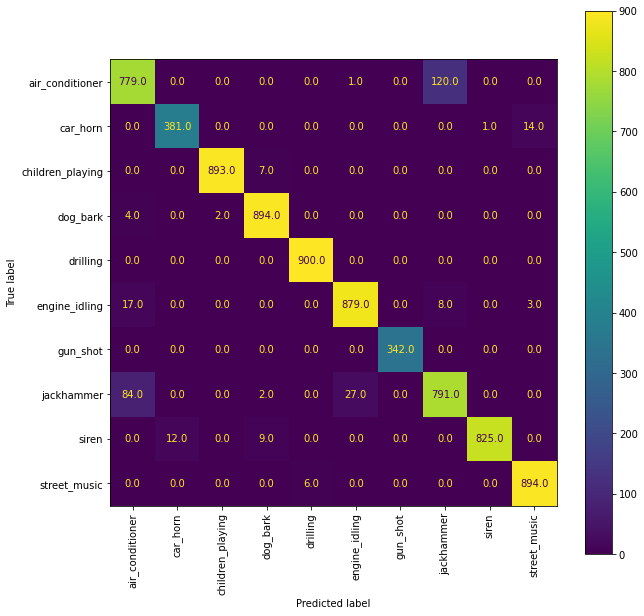

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multiclass, display_labels=classes);
disp.plot(xticks_rotation='vertical', values_format='.1f', ax=ax)

*Alternative accuracy (by hand)*

Compute metrics (**accuracy** only):
\begin{equation}
ACC = \frac{TP+TN}{TP+TN+FP+FN}
\end{equation}

In [14]:
def compute_accuracy(CM):
    #farla a mano? ma già esiste! LOL

SyntaxError: unexpected EOF while parsing (<ipython-input-14-0a8baeba8aa9>, line 2)

## Visualization

In [ ]:
## visualization

for c in classes:
    mfcc = train_features_matrix[c][0].transpose()
    # Visualization
    fig = plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.imshow(mfcc, origin='lower', aspect='auto')
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.title('MFCC (coefficients 0 to 13) for class {}'.format(c))
    plt.colorbar()
    plt.tight_layout()

    mfcc_upper = mfcc[4:]
    plt.subplot(1,2,2)
    plt.imshow(mfcc_upper, origin='lower', aspect='auto')
    plt.title('MFCC (coefficients 4 to 13) for class {}'.format(c))
    plt.xlabel('Training samples')
    plt.ylabel('MFCC coefficients')
    plt.colorbar()
    plt.tight_layout()